## This notebook contains experiments to try and detect events from an audio source


author: Tony Zhai

First let's load some packages:
pip install pyAudioAnalysis
pip install noisereduce

In [120]:
#! pip install pyAudioAnalysis
#! pip install noisereduce
from pyAudioAnalysis import ShortTermFeatures
from pyAudioAnalysis import audioSegmentation as aS
import matplotlib.pyplot as plt

# disable warnings to tidy up output
import warnings
warnings.filterwarnings("ignore")

# some basic libraries 
#import pandas as pd
#import seaborn as sns
import numpy as np
import pandas as pd
import noisereduce as nr
# plot support
import matplotlib.pyplot as plt
import soundfile as sf
import os
from google.cloud import storage
from scipy import signal
# reading audio datasets
import librosa
import librosa.display
import IPython
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

Let's load an audio file. Extracting some short term features using the python package:

In [47]:
path = r"audio\00003.mp3"

y, sr = librosa.load(path)


In [30]:
# listen to the clip:
IPython.display.Audio(data=y, rate=sr)

As you can see it is a very long clip with few moments of birdcall.

We can try to use a silence removal package to detect the silences and remove them for audio cleaning:

How this works is described in the following link. "first an SVM model is trained to distingush between high-energy and low-energy short-term frames. Towards this end, 10% of the highest energy frames along with the 10% of the lowest ones are used. Then, the SVM is applied (with a probabilistic output) on the whole recording and a dynamic thresholding is used to detect the active segments."

https://github.com/tyiannak/pyAudioAnalysis/wiki/5.-Segmentation

I have found that using smooth_window = 0.5, weight = 0.5 gives detections thresholds that include most of the sounds we are trying to capture.

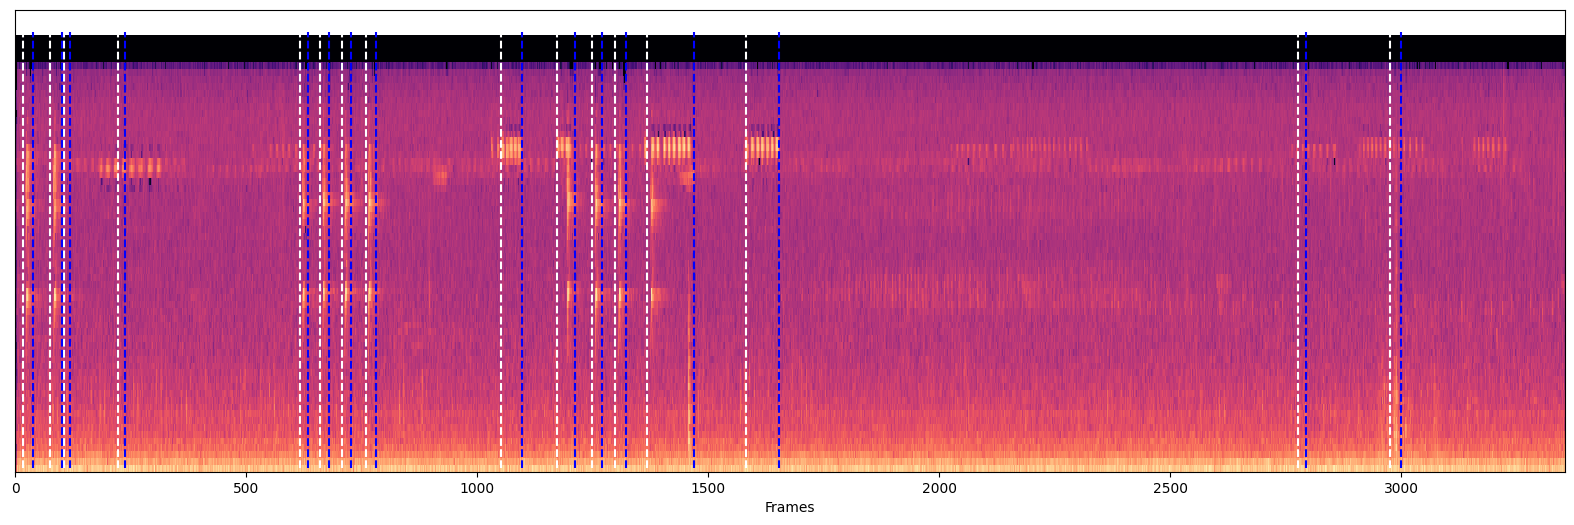

In [58]:
HOP_LEN= 512
segments = aS.silence_removal(y, sr, 0.020, 0.020, smooth_window = 0.5, weight = 0.5, plot = False)
frames = np.multiply(segments,sr/HOP_LEN)
start = [i[0] for i in frames]
finish = [i[1] for i in frames]
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
S1 = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, n_fft=2048, hop_length=HOP_LEN)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, ax = ax,  x_axis='frames')
#ax.plot(F[5]*25)
#ax.lines(flat)
ax.vlines(start, 0, 64 , linestyle='dashed', color = 'white')
ax.vlines(finish, 0, 64 , linestyle='dashed', color = 'blue')

Here we can see where the "event" sections are, as demarcated by the white and blue lines (white is the start of an event, and blue is the end). This appraoch is able to capture all of the birdcalls but also includes some cricket noises.

Perhaps we can do clustering on these segments to distinguish bird calls from other noises:
Hopefully we get some clustering like this:
[1,1,0,1,1,1,1,0,1,1,1,1,0,0,0] where 1 is the actual bird call and 0 is other sounds e.g. crickets.

We can try to do this by extracting the mfccs of the segments:
https://en.wikipedia.org/wiki/Mel-frequency_cepstrum


In [ ]:
# Have a listen to the first segment:
IPython.display.Audio(data=y[int(segments[0][0]*sr):int(segments[0][1]*sr)], rate=sr)

In [116]:
mfccs = []
for i in segments:
    start = int(i[0]*sr)
    finish = int(i[1]*sr)
    length = finish-start
    mfcc = librosa.feature.mfcc(y=y[start:finish], sr=sr, n_mfcc=13, hop_length = length+1)
    mfccs.append(mfcc)

print(np.shape(mfccs))
mfccs_1 = np.squeeze(mfccs)
print(np.shape(mfccs_1))

(15, 13, 1)
(15, 13)


In [109]:
df = pd.DataFrame(mfccs_1)
print(df.head())

           0          1          2          3          4          5   \
0 -539.661072  87.625122  24.595860  42.569260   1.274913  26.424263   
1 -599.583435  99.126160 -20.432083  77.769623 -25.842236  59.286182   
2 -582.372192  86.323196  -2.842476  71.911217 -18.867796  39.185070   
3 -581.796692  78.977127  -2.326947  56.141785 -18.653454  42.705578   
4 -590.394958  94.402603 -13.380426  77.058334 -27.165138  56.263592   

          6          7          8          9          10         11         12  
0   5.273478   7.812340  -0.756905   9.453733  10.183630   8.064299   7.488497  
1 -24.974628  36.831711 -14.750149  19.244326 -11.590471  15.292778  -4.159053  
2  -3.800822  24.287037  -7.089713  19.924477  -6.321638   5.900317  -1.168264  
3 -16.957432  27.101082  -2.938042  17.764256   1.198993  12.048553  16.721018  
4 -23.446507  37.821068 -14.006418  24.201496  -8.511074  15.651017  -0.691487  


In [159]:
# Scale the data
scaler = MinMaxScaler()
scaled_MFCC = pd.DataFrame(scaler.fit_transform(df), 
                                index=df.index)



In [122]:
scaled_MFCC.head()

0         1         2         3         4         5         6   \
0  1.305347  0.662456  1.651195 -1.278117  1.339499 -1.007342  1.992100   
1 -1.149401  1.657351 -1.691403  0.557683 -0.463803  1.025859 -1.669272   
2 -0.444334  0.549833 -0.385658  0.252150  0.000000 -0.217817  0.893704   
3 -0.420759 -0.085637 -0.347389 -0.570271  0.014254  0.000000 -0.698833   
4 -0.772991  1.248741 -1.167931  0.520587 -0.551777  0.838848 -1.484301   

         7         8         9         10        11        12  
0 -0.809938  0.190116 -0.455213  2.105349 -0.422070  0.733363  
1  0.796440 -1.353801  0.544298 -1.016554  0.343676 -0.253366  
2  0.102025 -0.508602  0.613734 -0.261125 -0.651311  0.000000  
3  0.257797 -0.050536  0.393199  0.817159  0.000000  1.515501  
4  0.851206 -1.271743  1.050370 -0.575040  0.381625  0.040390

In [123]:
# PCA to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
scaled_MFCC_PCA = pca.fit_transform(scaled_MFCC)
print(scaled_MFCC_PCA)

[[-3.6442132  -1.171075   -1.1057156 ]
 [ 3.910945   -0.7576041  -0.05563235]
 [ 0.5374325  -0.56365424 -0.8540185 ]
 [ 0.1989547  -1.1369061   1.2935832 ]
 [ 3.2796454  -0.79593706  0.1414143 ]
 [-1.4510127  -1.5501841   1.2955437 ]
 [ 0.23889008 -0.14112888  0.24652846]
 [-0.19721505  2.1785727   1.0185422 ]
 [ 0.39728326  1.5368576   0.17435212]
 [ 0.18537547 -0.8600221  -0.2103323 ]
 [-1.4820843  -0.92812127 -0.22103243]
 [ 2.678328    1.1062111  -1.1738176 ]
 [-1.6756976   3.1704988   0.09914663]
 [-1.8519218  -0.65142405 -0.23441172]
 [-1.1247104   0.5639162  -0.41414964]]


In [146]:
# k means clustering where we want 2 clusters:
km = KMeans(n_clusters=2).fit(scaled_MFCC_PCA)

km.labels_

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

These unfortunately don't line up with the graph we saw earlier. We're looking for something like [1,1,0,1,1,1,1,0,1,1,1,1,0,0,0] where 1 is the actual bird call. MFCCs are not good when there's noise so there's that. Maybe we can use some other feature extraction technique??:

In [250]:
STfeatures = []
for i in segments:
    start = int(i[0]*sr)
    finish = int(i[1]*sr)
    length = finish-start
    STfeature, f_names = ShortTermFeatures.feature_extraction(y[start:finish], sr, 512, 512)
    # Take the mean of each feature extracted:
    mean = np.mean(STfeature, axis=1)
    STfeatures.append(mean[0:8])

print(np.shape(STfeatures))
STfeatures = np.squeeze(STfeatures)
print(np.shape(STfeatures))


print (f_names[0:8])

(15, 8)
(15, 8)
['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff']


Here we have a list of audio features such as energy, spectral centroid etc extracted. You can read more about each feature here:
https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction


In [237]:
print(STfeatures[0:3, 0:4])

[[0.1388454  0.04102619 2.94005916 0.23043323]
 [0.13356164 0.02779504 2.91500988 0.22778927]
 [0.07876712 0.12383336 2.81233899 0.19448537]]


In [253]:
km = KMeans(n_clusters=2).fit(STfeatures)
print(km.labels_)

[0 0 1 0 0 0 0 0 0 0 0 0 0 1 1]


OK this is looking more promising as it's very similar to our desired array: [1,1,0,1,1,1,1,0,1,1,1,1,0,0,0]
We can also so scaling and PCA:

In [223]:
scaler = RobustScaler()
scaled_STfeatures = scaler.fit_transform(STfeatures)
pca = PCA(n_components=6)
scaled_STfeatures_PCA = pca.fit_transform(scaled_STfeatures)


In [224]:
km = KMeans(n_clusters=2).fit(scaled_STfeatures_PCA)
km.labels_

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

Not much difference.
Let's see if any individual short term feature does a good job in this instance:

In [254]:
for i in range(8):

    km = KMeans(n_clusters=2).fit(STfeatures[:, i:i+1])
    print(km.labels_)

[1 1 1 1 1 1 1 0 0 1 1 0 0 1 1]
[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 1 0 1 1 0 0 1 1 0 0]
[1 1 0 1 1 1 1 0 1 1 1 0 0 0 0]
[1 1 0 1 1 1 1 1 1 1 1 1 1 0 0]
[0 0 1 0 0 0 0 1 1 1 0 1 1 1 1]
[1 1 0 1 1 1 1 1 1 1 1 1 1 0 0]


compoared to [1,1,0,1,1,1,1,0,1,1,1,1,0,0,0], the 5th one, or sprectral spread seems to be a good fit at clustering the audio samples.

In [201]:
reduced_noise = nr.reduce_noise(y = y, sr=sr, n_std_thresh_stationary=2,stationary=True)

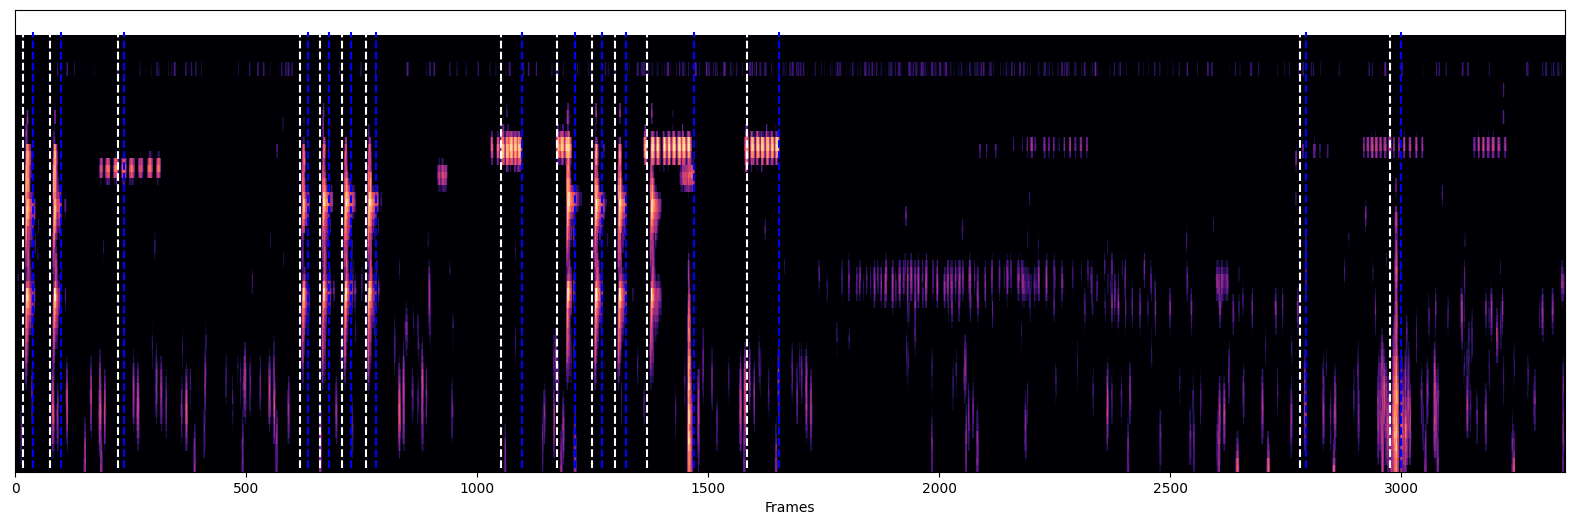

In [203]:
HOP_LEN= 512
segments = aS.silence_removal(y, sr, 0.020, 0.020, smooth_window = 0.5, weight = 0.5, plot = False)
frames = np.multiply(segments,sr/HOP_LEN)
start = [i[0] for i in frames]
finish = [i[1] for i in frames]
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
S1 = librosa.feature.melspectrogram(y=reduced_noise, sr=sr, n_mels=64, n_fft=2048, hop_length=HOP_LEN)
D1 = librosa.power_to_db(S1, ref=np.max)
librosa.display.specshow(D1, ax = ax,  x_axis='frames')
ax.vlines(start, 0, 64 , linestyle='dashed', color = 'white')
ax.vlines(finish, 0, 64 , linestyle='dashed', color = 'blue')

In [210]:
STfeatures = []
for i in segments:
    start = int(i[0]*sr)
    finish = int(i[1]*sr)
    length = finish-start
    STfeature, f_names = ShortTermFeatures.feature_extraction(reduced_noise[start:finish], sr, length, 1)
    STfeatures.append(STfeature[0:8])

print(np.shape(STfeatures))
STfeatures = np.squeeze(STfeatures)
print(np.shape(STfeatures))

km = KMeans(n_clusters=2).fit(STfeatures)

km.labels_

(15, 8, 1)
(15, 8)


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1])

compared to the noisy cersion, this isnt too much of an improvement.

In [255]:
# Have a listen though, it's pretty good ad getting rid of noise.
IPython.display.Audio(data=reduced_noise, rate=sr)

Based on all the above experiments, it is still very hard to differentiate animal sounds from environmental sounds using clustering. But with more fine tuning and other methods I'm sure there is a way to detect animal sounds in the future. 

Maybe we need to manually label some of this data and train a supervised model on individually labelled animal sounds. This is painstaking work however but the results might be worth it?

['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff']
